In [2]:
!pip3 install -U segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import tensorflow as tf
tf.keras.backend.set_image_data_format('channels_last')

     |████████████████████████████████| 50 kB 6.9 MB/s  eta 0:00:01
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [18]:
import sys
import os
import glob
import random
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from segmentation_models import Unet, Linknet, PSPNet, FPN
import keras
from segmentation_models.utils import set_trainable
from torch.utils.data import Dataset
import keras.backend as K
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.pytorch.transforms import ToTensor

In [4]:
# Path to all data
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"
# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)
IMG_SIZE = 256

In [10]:
# Creating a list of tuples containing directory names and file paths
data_map = [(sub_dir_path.split("/")[-1], os.path.join(sub_dir_path, filename))
            for sub_dir_path in glob.glob(DATA_PATH + "*")
            if os.path.isdir(sub_dir_path)
            for filename in os.listdir(sub_dir_path)]

df = pd.DataFrame({"dirname": [entry[0] for entry in data_map],
                   "path": [entry[1] for entry in data_map]})

# Separating images and masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Sorting data
imgs = sorted(df_imgs["path"].values, key=lambda x: int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x: int(x[BASE_LEN:-END_MASK_LEN]))

# Checking sorting
idx = random.randint(0, len(imgs) - 1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

# Creating the final DataFrame
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                   "image_path": imgs,
                   "mask_path": masks})

# Adding a diagnosis column
def positive_negative_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0:
        return 1
    else:
        return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positive_negative_diagnosis(m))

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_7.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_7_mask.tif


In [11]:
df

patient  \
0     TCGA_DU_7010_19860307   
1     TCGA_DU_7010_19860307   
2     TCGA_DU_7010_19860307   
3     TCGA_DU_7010_19860307   
4     TCGA_DU_7010_19860307   
...                     ...   
3924  TCGA_DU_7306_19930512   
3925  TCGA_DU_7306_19930512   
3926  TCGA_DU_7306_19930512   
3927  TCGA_DU_7306_19930512   
3928  TCGA_DU_7306_19930512   

                                             image_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  diagnosis  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
...                                                 ...        ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  

[3929 rows x 4 columns]

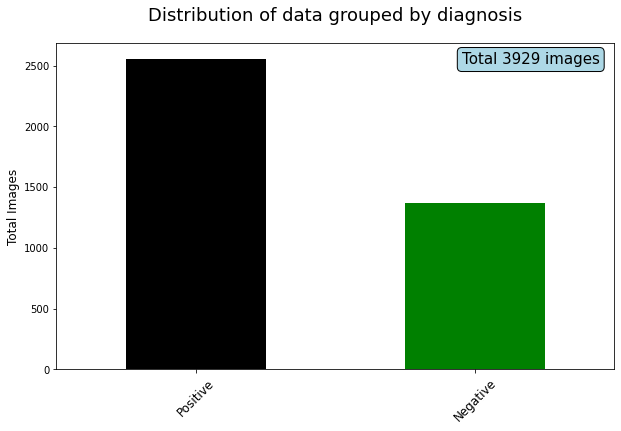

In [17]:
# Plot
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10, 6), color=["black", "green"])

ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12)
ax.set_ylabel('Total Images', fontsize=12)
ax.set_title("Distribution of data grouped by diagnosis", fontsize=18, y=1.05)

for i, count in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(count), xy=(i, count - 12), rotation=0, color="white", ha="center", verticalalignment='bottom', fontsize=15, fontweight="bold")

ax.text(1.2, 2550, f"Total {len(df)} images", size=15, color="black", ha="center", va="center",
        bbox=dict(boxstyle="round", fc=("lightblue"), ec=("black"))
)

plt.show()

In [19]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = crop_image_from_gray(image)
    image=cv2.addWeighted(image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

def normalizing(img):
    norm = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return norm

class Dataloder(keras.utils.Sequence):

    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
    
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true), axis=-1) + K.sum(K.square(y_pred), axis=-1) + smooth)

class BrainMriDataset(Dataset):
    def __init__(self, df, transforms, preprocessing=None):
        
        self.df = df
        self.transforms = transforms
        self.preprocessing = preprocessing
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = load_ben_color(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)
        mask = normalizing(mask)
        
        if self.preprocessing:
            image = self.preprocessing(image)
            
        augmented = self.transforms(image=image, 
                                    mask=mask)
 
        image = augmented['image']
        mask = augmented['mask']
        
        
        
        return image, mask

def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# Visualize the data

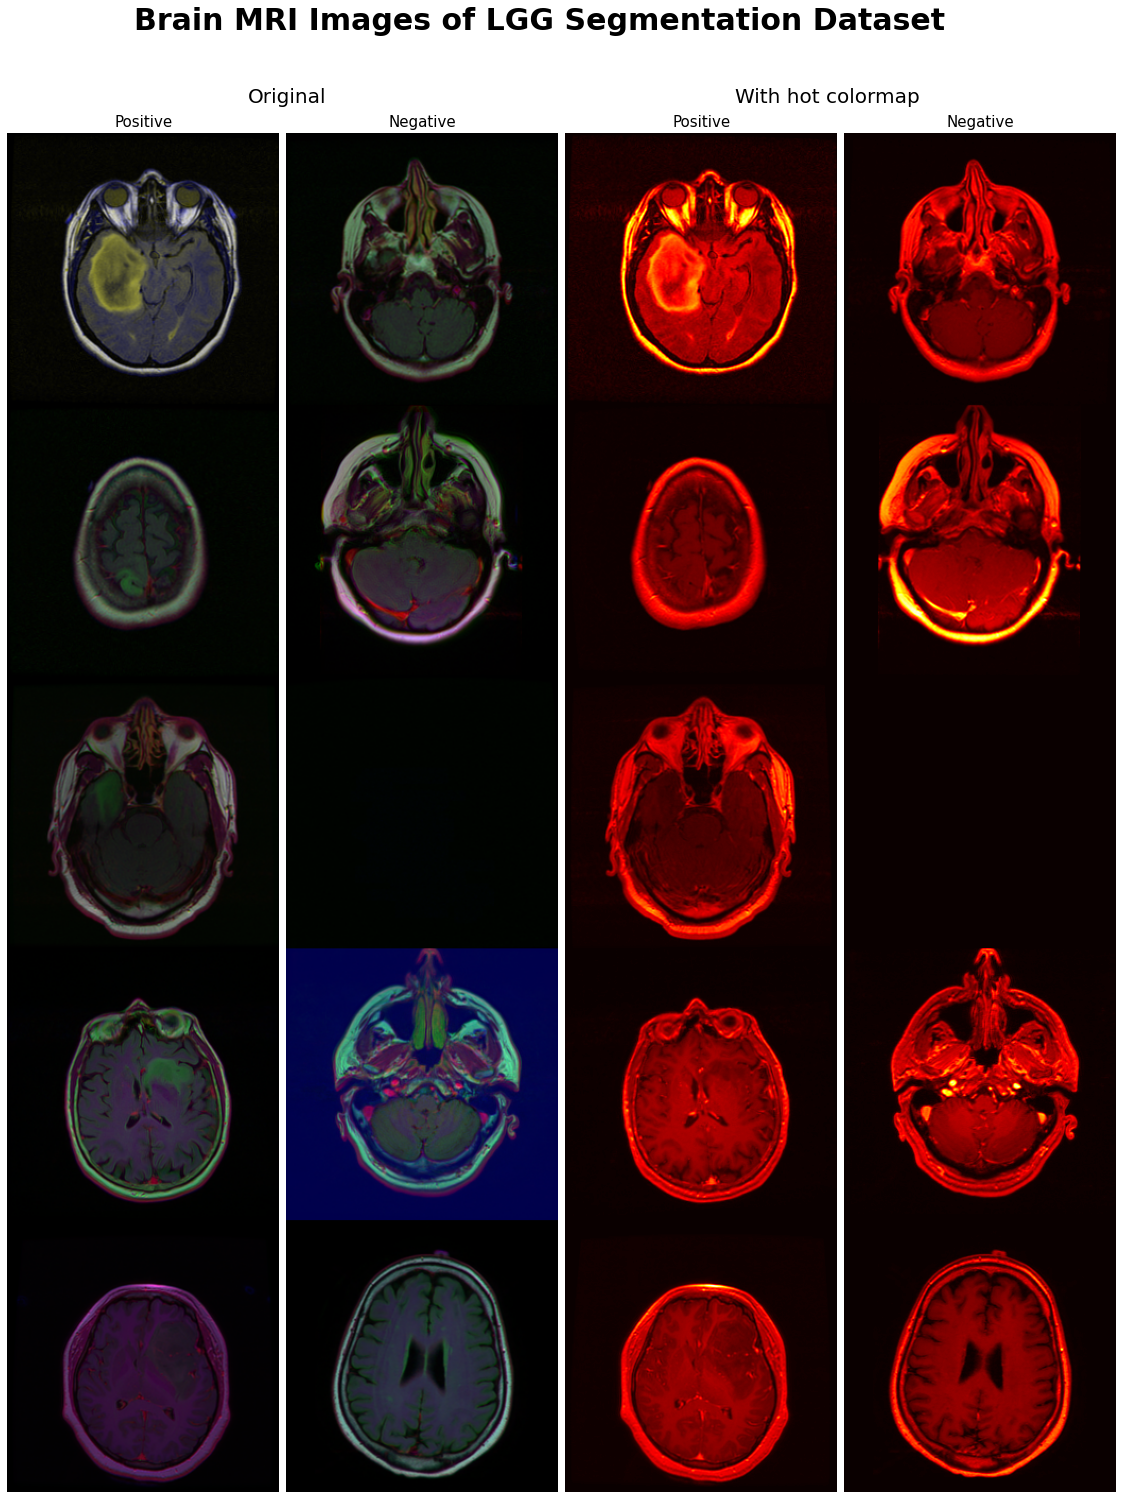

In [22]:
# Data
sample_yes_df = df[df["diagnosis"] == 1].sample(5)["image_path"].values
sample_no_df = df[df["diagnosis"] == 0].sample(5)["image_path"].values

sample_imgs = []
for yes, no in zip(sample_yes_df, sample_no_df):
    yes_image = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no_image = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes_image, no_image])

sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.1)

# Positive images
grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")

# Negative images
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

# Positive images with hot colormap
grid[2].imshow(sample_yes_arr[:, :, 0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")

# Negative images with hot colormap
grid[3].imshow(sample_no_arr[:, :, 0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")

# Annotations
plt.figtext(0.36, 0.90, "Original", va="center", ha="center", size=20)
plt.figtext(0.66, 0.90, "With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images of LGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# Save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()


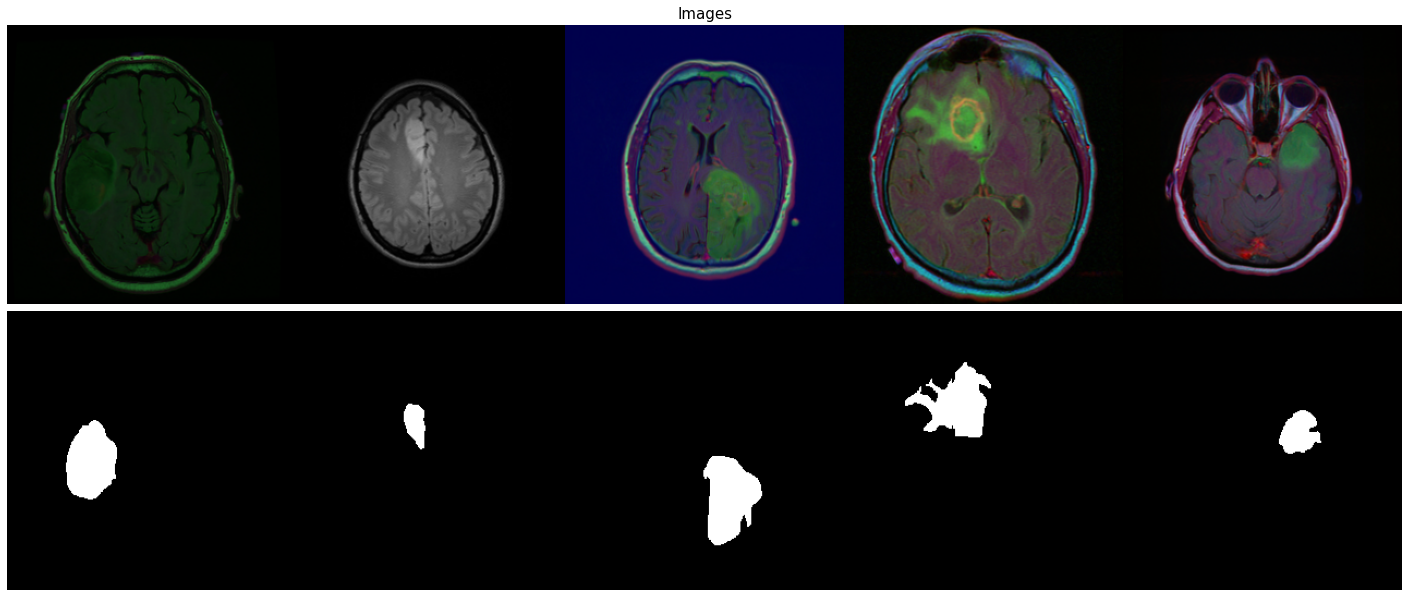

In [23]:
# Data
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []

for i, data in enumerate(sample_df):
    #print(data)
    img_path, mask_path = data[1], data[2]
    img = cv2.resize(cv2.imread(img_path), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(mask_path), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])

sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")

plt.show()

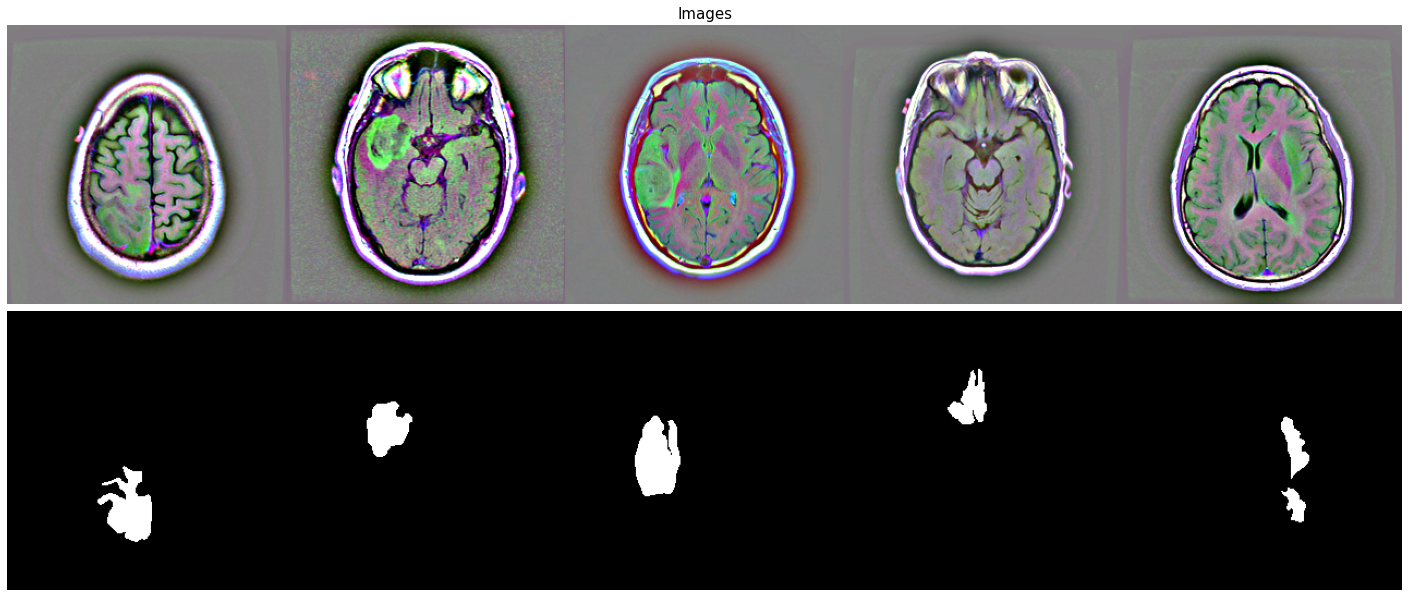

In [24]:
# Data
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []

for i, data in enumerate(sample_df):
    img = load_ben_color(data[1])
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])

sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 1), axes_pad=0.1)

grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")

grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")

plt.show()


# Prepare the training and testing set

In [25]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1, shuffle=True)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

In [26]:
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


# Data Augmentation

In [27]:
PATCH_SIZE = 256
transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.GaussianBlur(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
])

# Training 

# LINKNET - VGG16

In [28]:
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)
n_classes = 1
activation = 'sigmoid'
model = sm.Linknet(BACKBONE, classes=n_classes, activation=activation, encoder_weights="imagenet", encoder_freeze=True)
optim = keras.optimizers.Adam(0.001)
total_loss = sm.losses.binary_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),dice_coefficient]
model.compile(optim, total_loss, metrics)

58892288/58889256 [==============================] - 3s 0us/step


In [30]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms, preprocessing=preprocess_input)
train_dataloader = Dataloder(train_dataset, batch_size=26, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms, preprocessing=preprocess_input)
val_dataloader = Dataloder(val_dataset, batch_size=26, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms, preprocessing=preprocess_input)
test_dataloader = Dataloder(test_dataset, batch_size=26, shuffle=True)

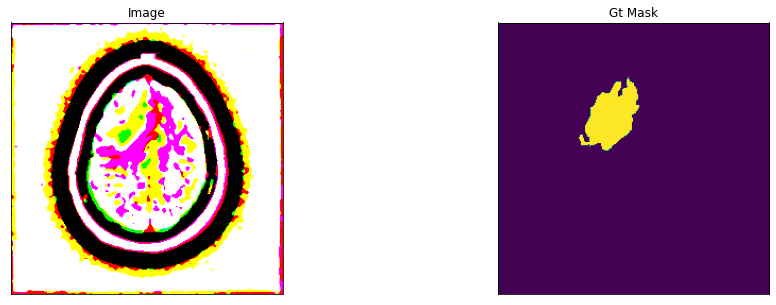

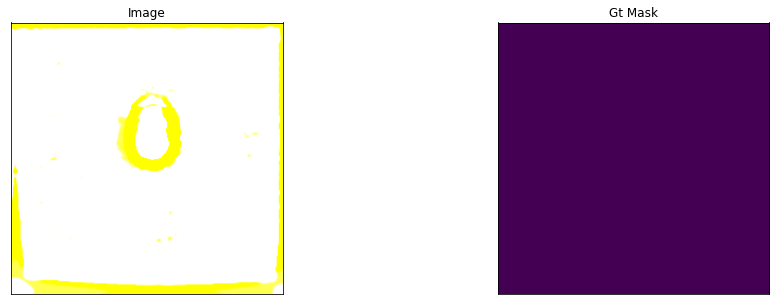

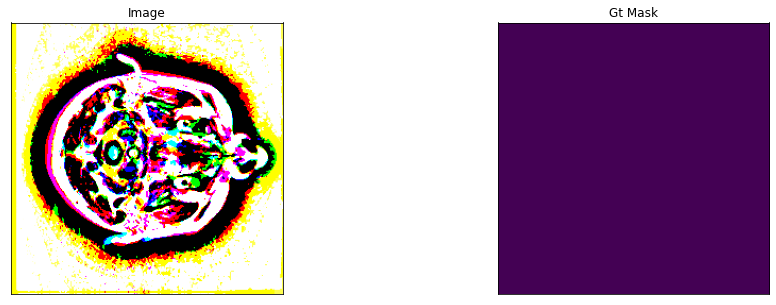

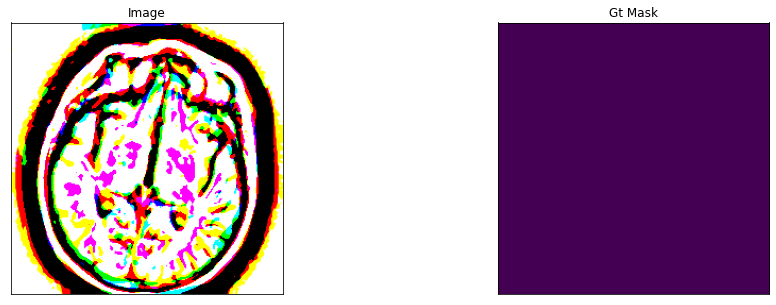

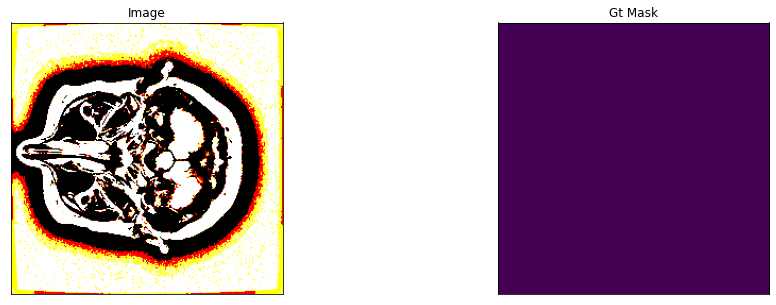

In [32]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:

    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    

    visualize(
        image=image.squeeze(),
        gt_mask=gt_mask.squeeze(),
        
    )

In [103]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [104]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=40, 
    validation_data=val_dataloader, 
    validation_steps=len(val_dataloader),
)

Epoch 1/40
115/115 [==============================] - 48s 399ms/step - loss: 1.0146 - iou_score: 0.0550 - f1-score: 0.0986 - dice_coefficient: 0.1230 - val_loss: 0.9034 - val_iou_score: 0.1752 - val_f1-score: 0.2968 - val_dice_coefficient: 0.5769
Epoch 2/40
115/115 [==============================] - 45s 389ms/step - loss: 0.6456 - iou_score: 0.2832 - f1-score: 0.4364 - dice_coefficient: 0.8571 - val_loss: 0.5902 - val_iou_score: 0.2963 - val_f1-score: 0.4519 - val_dice_coefficient: 0.9136
Epoch 3/40
115/115 [==============================] - 45s 388ms/step - loss: 0.5257 - iou_score: 0.3471 - f1-score: 0.5100 - dice_coefficient: 0.8944 - val_loss: 0.5608 - val_iou_score: 0.3055 - val_f1-score: 0.4628 - val_dice_coefficient: 0.9353
Epoch 4/40
115/115 [==============================] - 44s 385ms/step - loss: 0.4998 - iou_score: 0.3657 - f1-score: 0.5296 - dice_coefficient: 0.9125 - val_loss: 0.4984 - val_iou_score: 0.3603 - val_f1-score: 0.5243 - val_dice_coefficient: 0.9385
Epoch 5/40
1

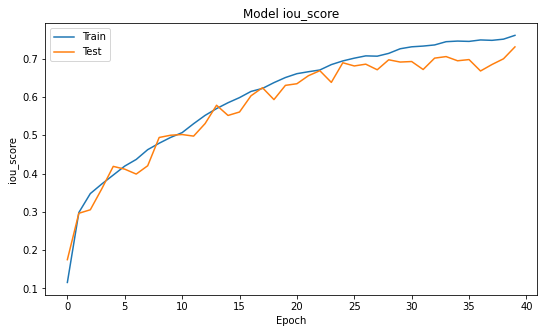

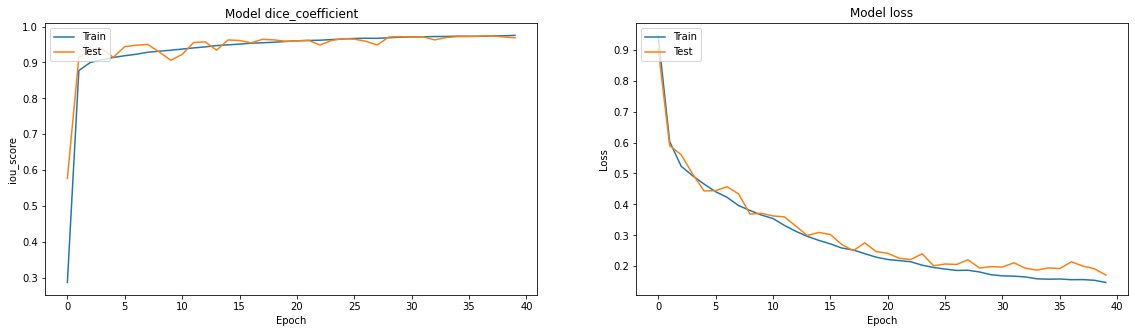

In [105]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(131)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation dice_coefficient values
plt.figure(figsize=(30, 5))
plt.subplot(132)
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('Model dice_coefficient')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(133)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [107]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

20/20 [==============================] - 6s 319ms/step - loss: 0.2157 - iou_score: 0.6735 - f1-score: 0.7989 - dice_coefficient: 0.9674
Loss: 0.21573
mean iou_score: 0.67349
mean f1-score: 0.79887
mean dice_coefficient: 0.96739


In [108]:
model.save_weights("weights-LinkNet_VGG16.hdf5")

In [109]:
np.save('LinkNetVGG16.npy',history.history)

In [ ]:
#model.load_weights('')

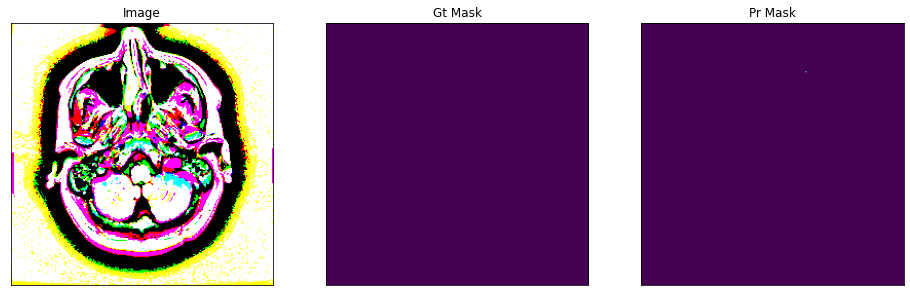

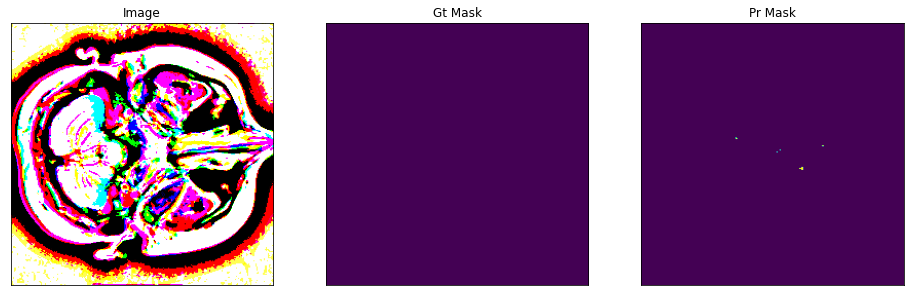

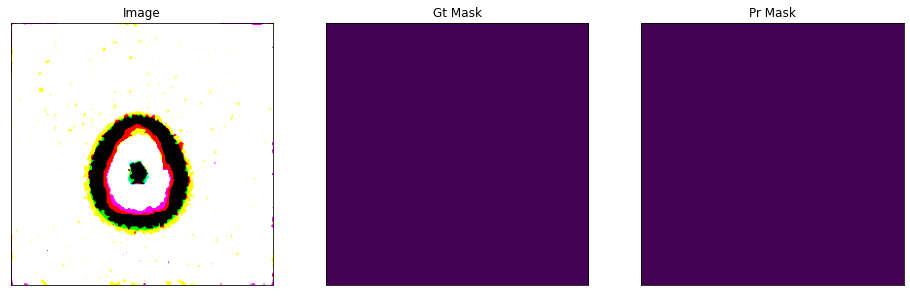

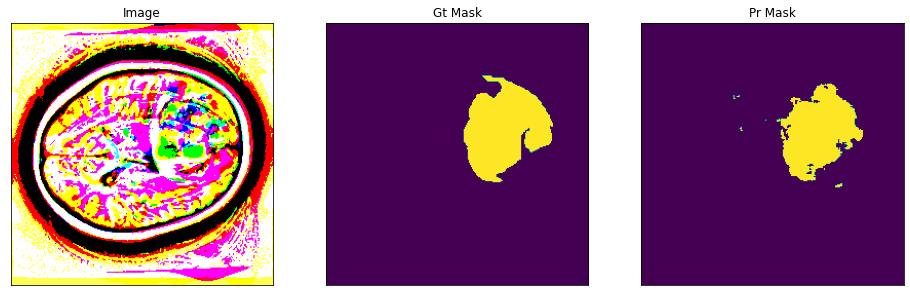

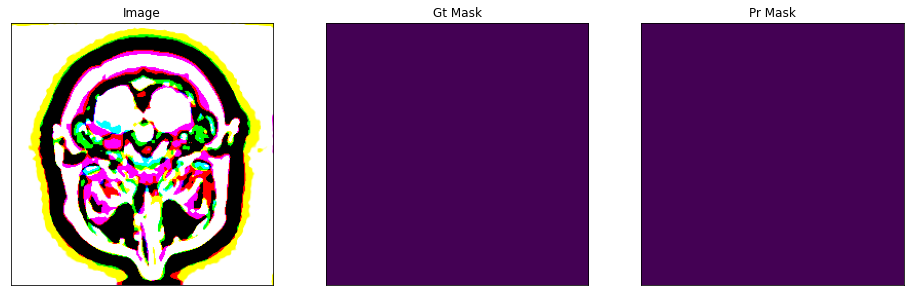

In [110]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=image.squeeze(),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

# UNET - VGG16

In [111]:
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 # case for binary and multiclass segmentation
activation = 'sigmoid'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', encoder_freeze=True)

# define optomizer
optim = keras.optimizers.Adam(0.001)
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),dice_coefficient]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [112]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms, preprocessing=preprocess_input)
train_dataloader = Dataloder(train_dataset, batch_size=26, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms, preprocessing=preprocess_input)
val_dataloader = Dataloder(val_dataset, batch_size=26, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms, preprocessing=preprocess_input)
test_dataloader = Dataloder(test_dataset, batch_size=26, shuffle=True)

In [113]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [114]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=40, 
    validation_data=val_dataloader, 
    validation_steps=len(val_dataloader),
)

Epoch 1/40
115/115 [==============================] - 49s 395ms/step - loss: 0.9378 - iou_score: 0.1247 - f1-score: 0.1988 - dice_coefficient: 0.2583 - val_loss: 0.6122 - val_iou_score: 0.3384 - val_f1-score: 0.4997 - val_dice_coefficient: 0.9244
Epoch 2/40
115/115 [==============================] - 45s 387ms/step - loss: 0.3991 - iou_score: 0.4722 - f1-score: 0.6354 - dice_coefficient: 0.9351 - val_loss: 0.4064 - val_iou_score: 0.4553 - val_f1-score: 0.6169 - val_dice_coefficient: 0.9579
Epoch 3/40
115/115 [==============================] - 44s 386ms/step - loss: 0.2820 - iou_score: 0.5878 - f1-score: 0.7370 - dice_coefficient: 0.9577 - val_loss: 0.5278 - val_iou_score: 0.3778 - val_f1-score: 0.5394 - val_dice_coefficient: 0.9022
Epoch 4/40
115/115 [==============================] - 45s 389ms/step - loss: 0.2323 - iou_score: 0.6478 - f1-score: 0.7834 - dice_coefficient: 0.9615 - val_loss: 0.2283 - val_iou_score: 0.6619 - val_f1-score: 0.7934 - val_dice_coefficient: 0.9592
Epoch 5/40
1

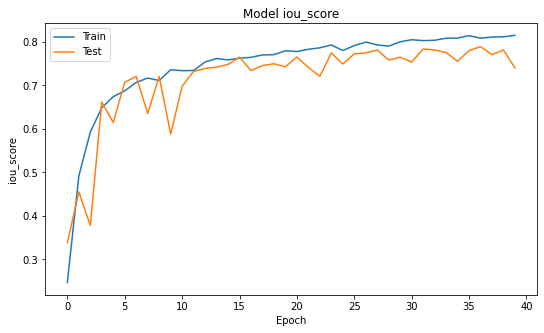

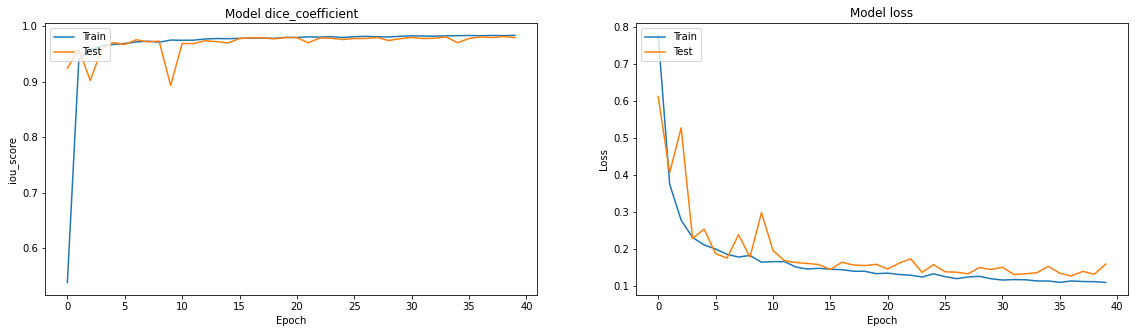

In [115]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(131)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation dice_coefficient values
plt.figure(figsize=(30, 5))
plt.subplot(132)
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('Model dice_coefficient')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(133)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [116]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

20/20 [==============================] - 7s 359ms/step - loss: 0.1912 - iou_score: 0.6973 - f1-score: 0.8174 - dice_coefficient: 0.9783
Loss: 0.19119
mean iou_score: 0.69734
mean f1-score: 0.8174
mean dice_coefficient: 0.97833


In [117]:
model.save_weights("weights-UNet_vgg16.hdf5")

In [118]:
np.save('Unet_vgg16_history.npy',history.history)

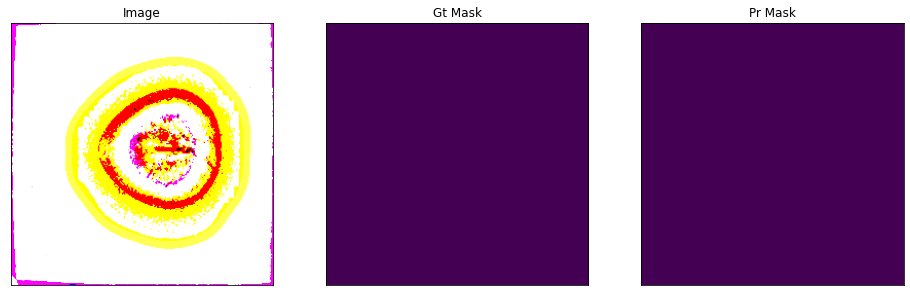

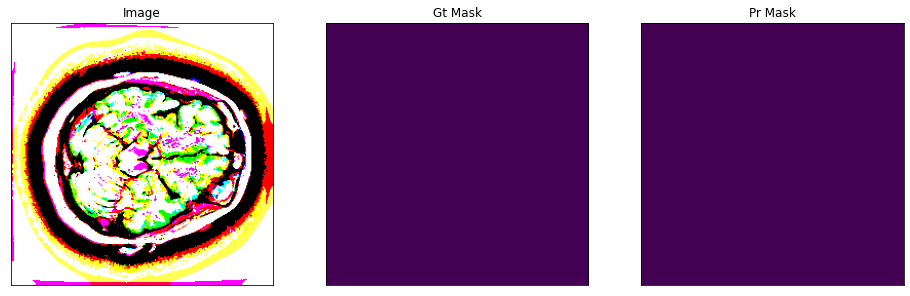

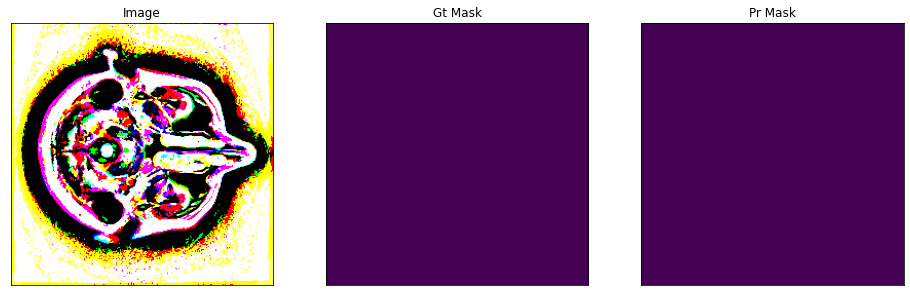

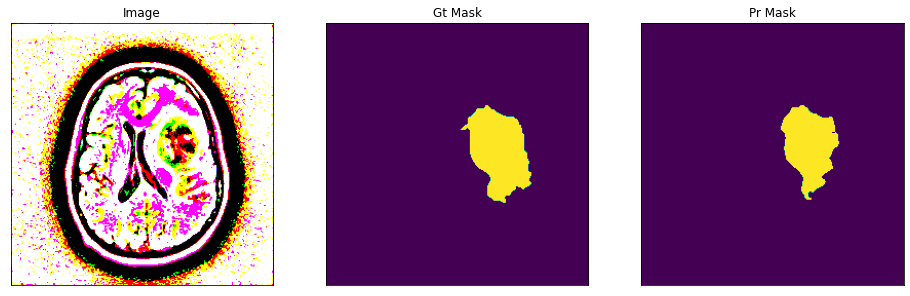

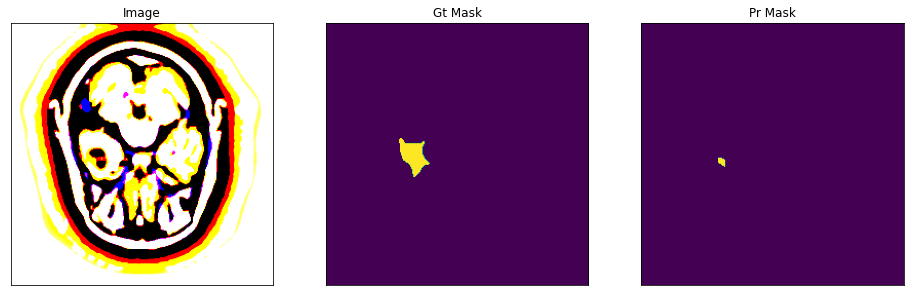

In [119]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=image.squeeze(),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

# LINKNET - INCEPTIONV3

In [120]:
BACKBONE = 'inceptionv3'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1
activation = 'sigmoid'
model = sm.Linknet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None, encoder_freeze=True)
optim = keras.optimizers.Adam(0.001)
total_loss = sm.losses.binary_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),dice_coefficient]
model.compile(optim, total_loss, metrics)

In [121]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms, preprocessing=preprocess_input)
train_dataloader = Dataloder(train_dataset, batch_size=26, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms, preprocessing=preprocess_input)
val_dataloader = Dataloder(val_dataset, batch_size=26, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms, preprocessing=preprocess_input)
test_dataloader = Dataloder(test_dataset, batch_size=26, shuffle=True)

In [122]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [123]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=40, 
    validation_data=val_dataloader, 
    validation_steps=len(val_dataloader),
)

Epoch 1/40
115/115 [==============================] - 62s 469ms/step - loss: 0.9124 - iou_score: 0.1148 - f1-score: 0.1878 - dice_coefficient: 0.3379 - val_loss: 0.9878 - val_iou_score: 7.1371e-10 - val_f1-score: 7.1371e-10 - val_dice_coefficient: 0.8840
Epoch 2/40
115/115 [==============================] - 47s 409ms/step - loss: 0.5223 - iou_score: 0.3458 - f1-score: 0.5076 - dice_coefficient: 0.9166 - val_loss: 1.0249 - val_iou_score: 7.1344e-10 - val_f1-score: 7.1344e-10 - val_dice_coefficient: 0.9279
Epoch 3/40
115/115 [==============================] - 46s 402ms/step - loss: 0.4675 - iou_score: 0.3923 - f1-score: 0.5574 - dice_coefficient: 0.9225 - val_loss: 1.0074 - val_iou_score: 0.0068 - val_f1-score: 0.0133 - val_dice_coefficient: 0.9294
Epoch 4/40
115/115 [==============================] - 46s 398ms/step - loss: 0.4295 - iou_score: 0.4271 - f1-score: 0.5936 - dice_coefficient: 0.9276 - val_loss: 0.4890 - val_iou_score: 0.3725 - val_f1-score: 0.5303 - val_dice_coefficient: 0.9

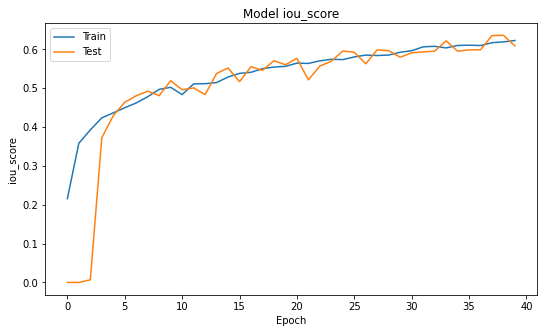

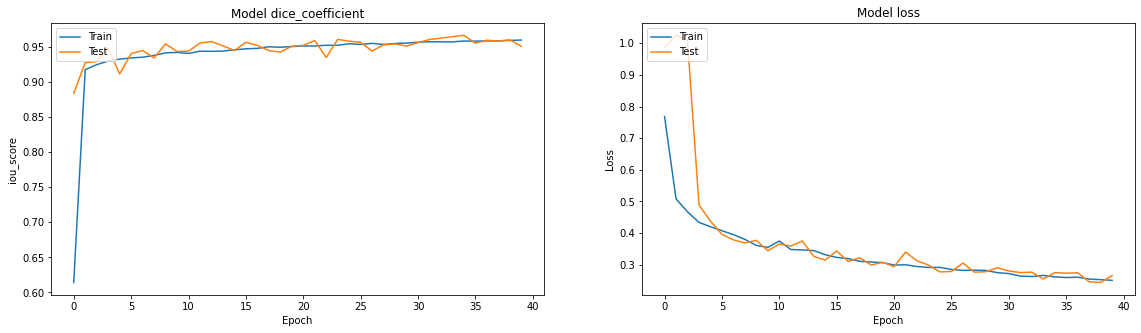

In [125]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(131)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation dice_coefficient values
plt.figure(figsize=(30, 5))
plt.subplot(132)
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('Model dice_coefficient')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(133)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [126]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

20/20 [==============================] - 7s 367ms/step - loss: 0.2728 - iou_score: 0.5992 - f1-score: 0.7440 - dice_coefficient: 0.9523
Loss: 0.27285
mean iou_score: 0.59918
mean f1-score: 0.74399
mean dice_coefficient: 0.95232


In [127]:
model.save_weights("weights-LinkNet_InceptionV3.hdf5")

In [128]:
np.save('UNet+InceptionV3_history.npy',history.history)

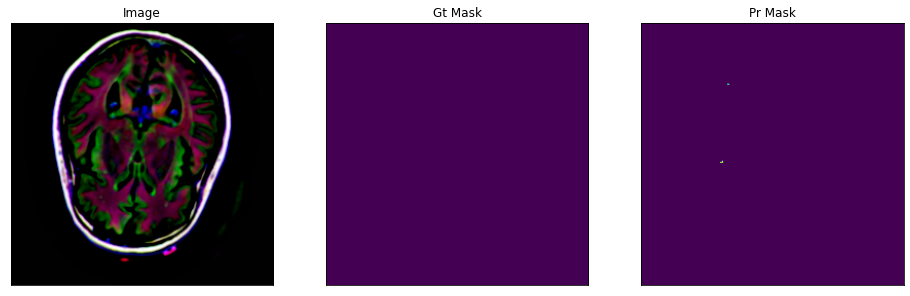

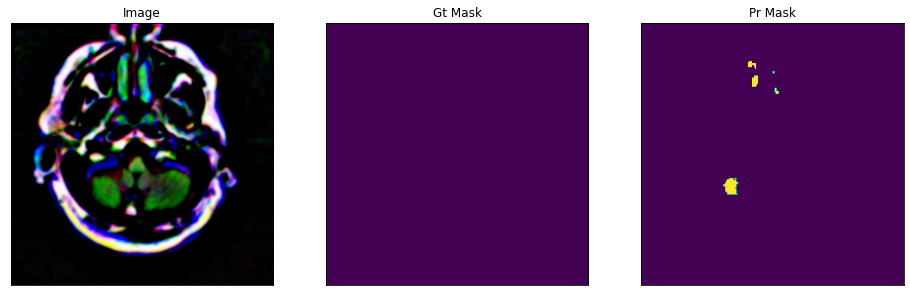

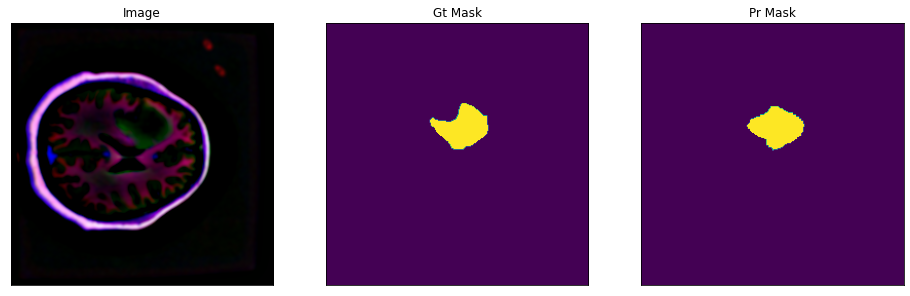

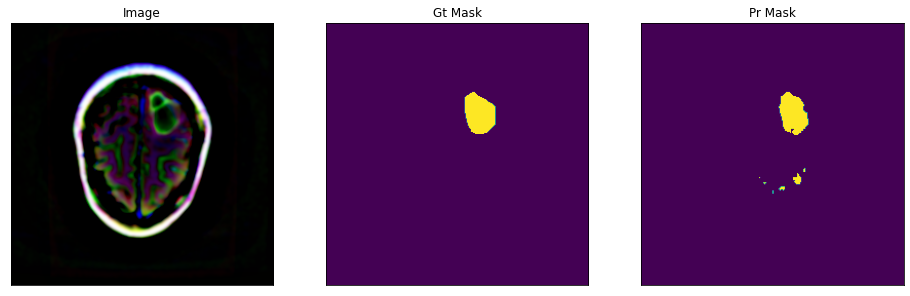

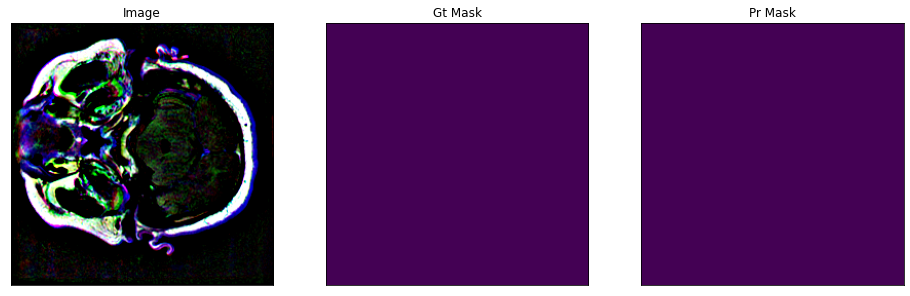

In [129]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=image.squeeze(),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

# UNET - INCEPTIONV3

In [33]:
BACKBONE = 'inceptionv3'
preprocess_input = sm.get_preprocessing(BACKBONE)
n_classes = 1
activation = 'sigmoid'
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None, encoder_freeze=True)
optim = keras.optimizers.Adam(0.001)
total_loss = sm.losses.binary_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),dice_coefficient]
model.compile(optim, total_loss, metrics)

In [34]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [35]:
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=40, 
    validation_data=val_dataloader, 
    validation_steps=len(val_dataloader),
)

Epoch 1/40
115/115 [==============================] - 105s 768ms/step - loss: 0.8886 - iou_score: 0.2366 - f1-score: 0.3565 - dice_coefficient: 0.3402 - val_loss: 1.0091 - val_iou_score: 3.6902e-05 - val_f1-score: 7.3762e-05 - val_dice_coefficient: 0.9213
Epoch 2/40
115/115 [==============================] - 49s 421ms/step - loss: 0.4275 - iou_score: 0.4417 - f1-score: 0.6061 - dice_coefficient: 0.9397 - val_loss: 0.5423 - val_iou_score: 0.3360 - val_f1-score: 0.4888 - val_dice_coefficient: 0.9482
Epoch 3/40
115/115 [==============================] - 48s 416ms/step - loss: 0.3984 - iou_score: 0.4633 - f1-score: 0.6255 - dice_coefficient: 0.9456 - val_loss: 0.3471 - val_iou_score: 0.5203 - val_f1-score: 0.6731 - val_dice_coefficient: 0.9540
Epoch 4/40
115/115 [==============================] - 48s 413ms/step - loss: 0.3514 - iou_score: 0.5106 - f1-score: 0.6687 - dice_coefficient: 0.9514 - val_loss: 0.3387 - val_iou_score: 0.5260 - val_f1-score: 0.6831 - val_dice_coefficient: 0.9447
Epo

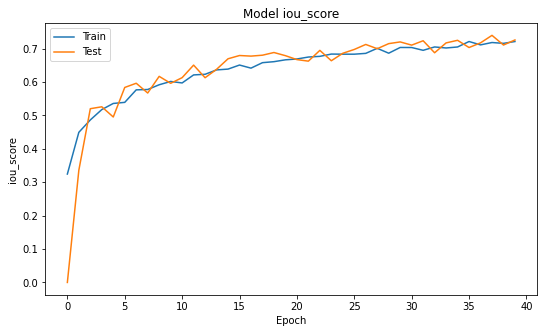

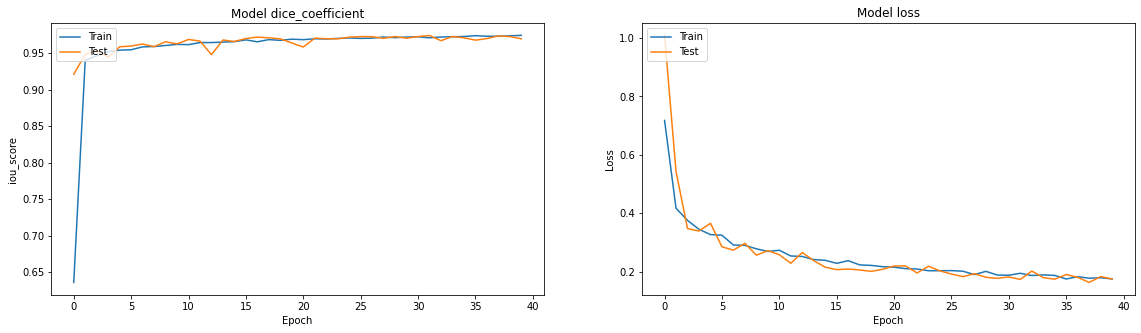

In [36]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(131)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation dice_coefficient values
plt.figure(figsize=(30, 5))
plt.subplot(132)
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('Model dice_coefficient')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(133)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [37]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

20/20 [==============================] - 13s 655ms/step - loss: 0.1802 - iou_score: 0.7158 - f1-score: 0.8318 - dice_coefficient: 0.9721
Loss: 0.18018
mean iou_score: 0.71578
mean f1-score: 0.8318
mean dice_coefficient: 0.97205


In [38]:
model.save_weights("weights-Unet_InceptionV3.hdf5")

In [39]:
np.save('UNet2+InceptionV3_history.npy',history.history)

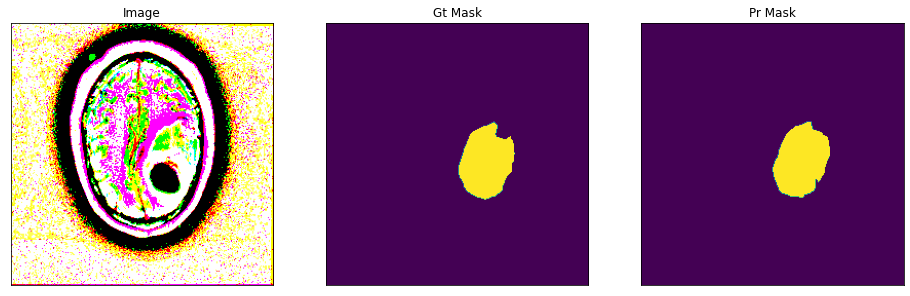

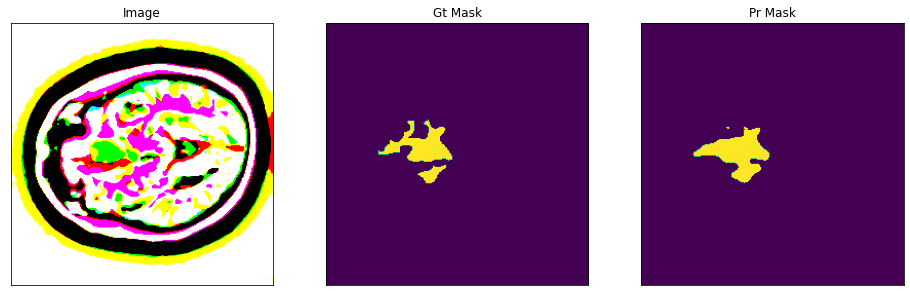

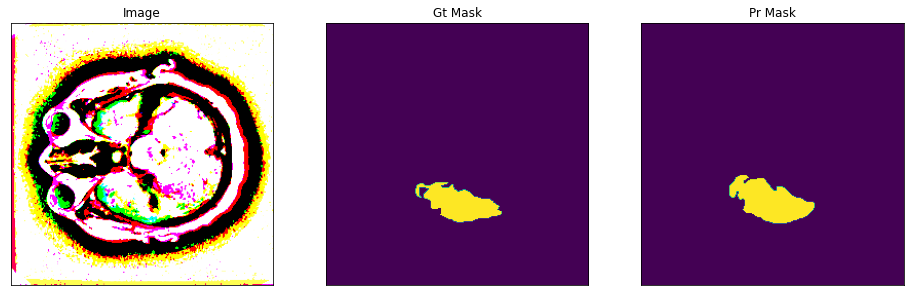

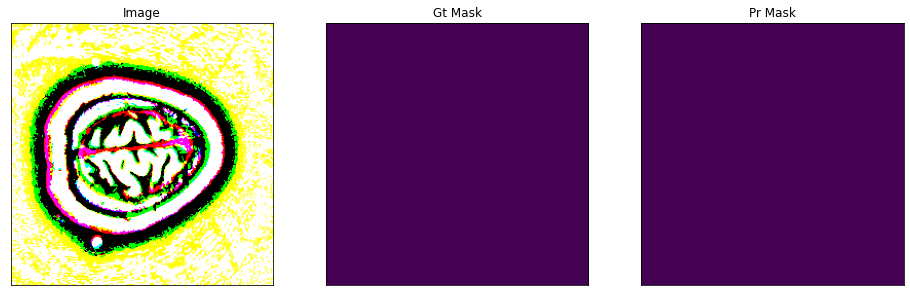

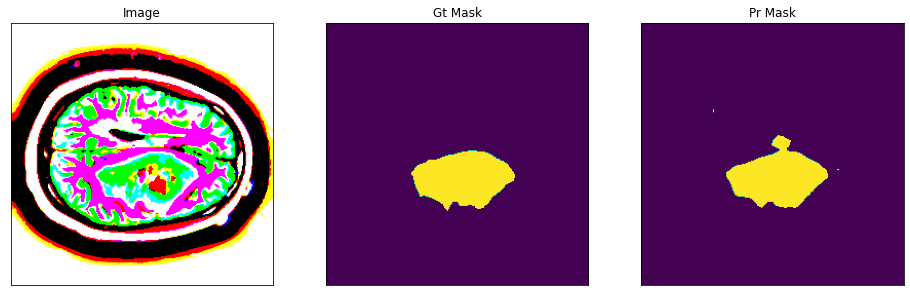

In [42]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=image.squeeze(),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

# PIPELINE

In [43]:
DATA_PATH_TEST = "/kaggle/input/testing/"

BASE_LEN = 66 
END_IMG_LEN = 4 
END_MASK_LEN = 9 

# img size
IMG_SIZE = 256

In [44]:
# Creating a list of tuples containing directory names and file paths
data_map = [(sub_dir_path.split("/")[-1], os.path.join(sub_dir_path, filename))
            for sub_dir_path in glob.glob(DATA_PATH_TEST + "*")
            if os.path.isdir(sub_dir_path)
            for filename in os.listdir(sub_dir_path)]

df = pd.DataFrame({"dirname": [entry[0] for entry in data_map],
                   "path": [entry[1] for entry in data_map]})

# Separating images and masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Sorting data
imgs = sorted(df_imgs["path"].values, key=lambda x: int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x: int(x[BASE_LEN:-END_MASK_LEN]))

# Checking sorting
idx = random.randint(0, len(imgs) - 1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

# Creating the final DataFrame
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                   "image_path": imgs,
                   "mask_path": masks})

# Adding a diagnosis column
def positive_negative_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0:
        return 1
    else:
        return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positive_negative_diagnosis(m))

Path to the Image: /kaggle/input/testing/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif 
Path to the Mask: /kaggle/input/testing/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif


In [45]:
check_dataset = BrainMriDataset(df=df, transforms=transforms, preprocessing=preprocess_input)
check_dataloader = Dataloder(test_dataset, batch_size=26, shuffle=True)

In [47]:
import numpy as np
from tensorflow.keras.models import load_model
BACKBONE = 'inceptionv3'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 # case for binary and multiclass segmentation
activation = 'sigmoid'

#create model
model1 = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None, encoder_freeze=True)
model1.load_weights("/kaggle/working/weights-Unet_InceptionV3.hdf5")
model1.summary()
history = np.load('/kaggle/working/UNet2+InceptionV3_history.npy', allow_pickle=True).item()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

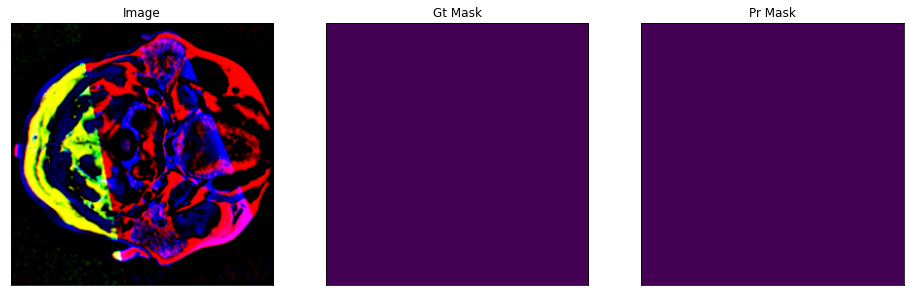

In [48]:
n = 5

image, gt_mask = check_dataset[0]
image = np.expand_dims(image, axis=0)
pr_mask = model1.predict(image).round()
visualize(
    image=image.squeeze(),
    gt_mask=gt_mask.squeeze(),
    pr_mask=pr_mask.squeeze(),
)